In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import copy
from keras.layers import LSTM
from keras import optimizers as opt

from collections import Counter

from tangle import read_activations
from tangle import model as mbs_model
from tangle.mbspbs10pc import utils

%matplotlib inline

# Load data

In [15]:
labelsfile = '../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv'
datafile = '../../tmp/item_days_raw_data_.pkl'
dataset = utils.load_data_labels(datafile, labelsfile)
padded_mbs_seq, padded_timespan_seq, tokenizer = utils.tokenize(dataset)
maxlen = padded_mbs_seq.shape[1]

# Split in training, validation, test sets
tr_set, v_set, ts_set = utils.train_validation_test_split(
    [padded_mbs_seq, padded_timespan_seq], dataset['Class'],
    test_size=0.4, validation_size=0.1,
    verbose=False)

# Load model

In [16]:
model = mbs_model.build_tangle(mbs_input_shape=(maxlen,),
                               timespan_input_shape=(maxlen, 1),
                               vocabulary_size=2774,
                               embedding_size=50,
                               recurrent_units=32,
                               dense_units=32,
                               attention_units=128,
                               bidirectional=True,
                               LSTMLayer=LSTM)

model.load_weights('model.h5')

# Visualize the attention weights

In [17]:
D = copy(ts_set)

alpha = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='tangle_attention')[0]
omega = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='contribution')[0]

----- activations -----
(4698, 250, 64)
----- activations -----
(4698, 250, 64)


In [18]:
W_fc = model.get_layer(name='fc').get_weights()[0]
W_out = model.get_layer(name='fc_output').get_weights()[0]
W = W_fc.dot(W_out)  # E x 1
We = model.get_layer(name='mbs_embedding').get_weights()[0]  # 2774 x E
w = We[D[0][0]].dot(W).squeeze()  # 6341 x T
print(w.shape)

(4698, 250)


In [19]:
# avg_alpha = np.mean(alpha, axis=-1).squeeze()
avg_omega = np.mean(omega, axis=-1).squeeze()
avg_omega.shape

(4698, 250)

In [20]:
c = w * avg_omega
print(c.shape)

(4698, 250)


In [21]:
neg = np.where(D[1] == 0)[0]
pos = np.where(D[1] == 1)[0]

Group class attention:

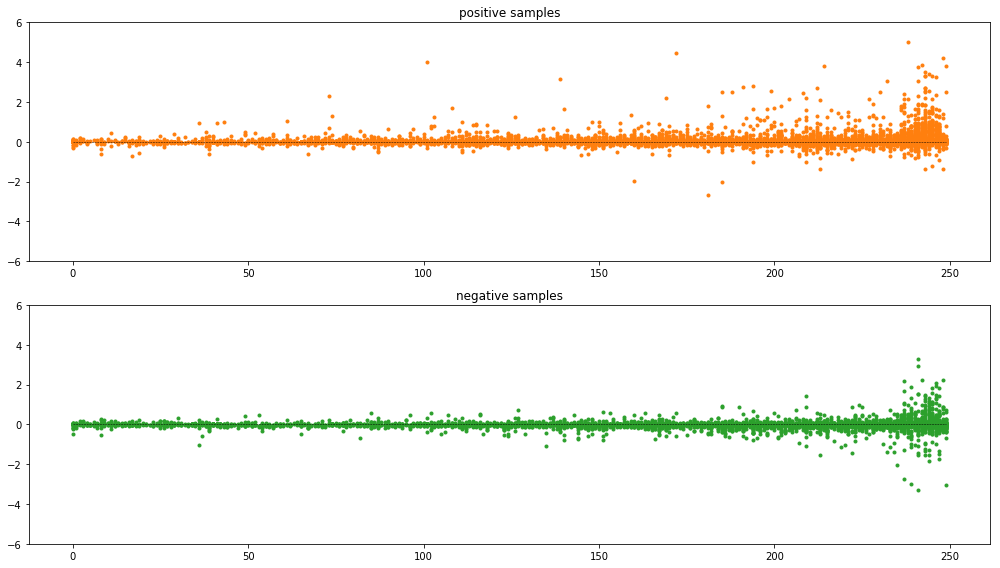

In [22]:
def zero_to_nan(row, p=75):
    out = np.array(row)
    _idx = np.where(np.abs(row) < np.percentile(np.abs(row), p))[0]
    out[_idx] = float('nan')
    return out


xaxis = np.arange(avg_omega.shape[1])

plt.figure(figsize=(14, 8))
plt.subplot(2,1,1)
for i in pos[:100]:
    plt.plot(xaxis, zero_to_nan(c[i, :].T), '.', color='C1')
plt.plot(xaxis, np.zeros_like(xaxis), '--', color='k', linewidth=0.5)
# plt.xlim([150, 250])
plt.ylim([-6, 6])
plt.title('positive samples')

plt.subplot(2,1,2)
for i in neg[:100]:
    plt.plot(xaxis, zero_to_nan(c[i, :].T), '.', color='C2')
plt.plot(xaxis, np.zeros_like(xaxis), '--', color='k', linewidth=0.5)
# plt.xlim([150, 250])
plt.ylim([-6, 6])
plt.title('negative samples')

plt.tight_layout();

Single attention:

In [27]:
# Build an inverse word map
word_map = {tokenizer.word_index[k]: k for k in tokenizer.word_index.keys()}
word_map[0] = 0

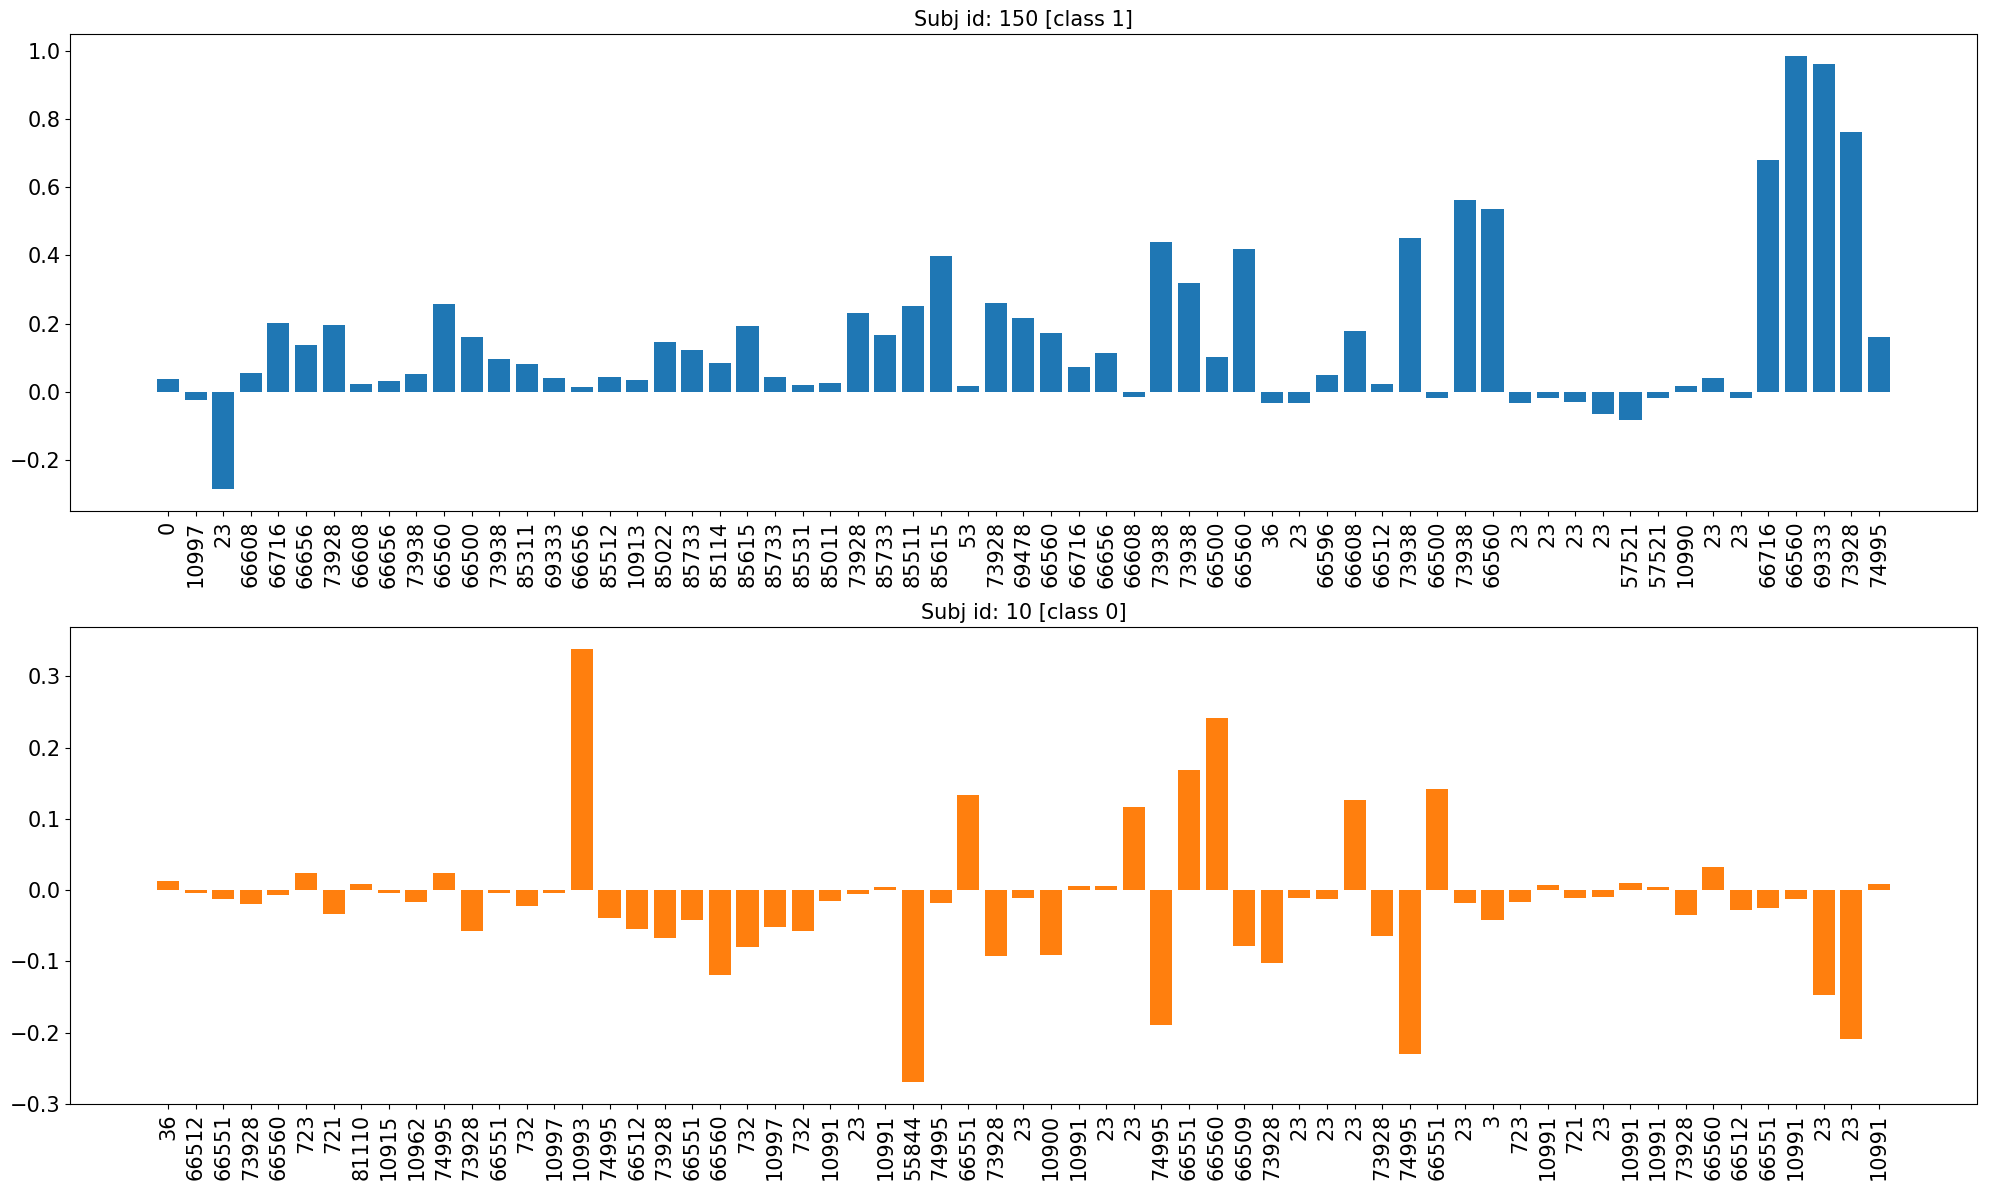

In [46]:
def attention_viz(i, color='C0'):
    # Load the mbs sequence from the dataset
    tokenized_seq = D[0][0][i]
    mbs_seq = np.array([word_map[tk] for tk in tokenized_seq])
    
    # Retrieve the corresponding attention vector
    attention = c[i].squeeze()
    
    # Filter out small attentions
    _idx = np.where(np.abs(attention) >= np.percentile(np.abs(attention), 75))[0]
    axis = np.arange(len(_idx))
    
    plt.bar(axis, attention[_idx], color=color)
    plt.xticks(axis, mbs_seq[_idx], rotation='vertical', fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Subj id: {} [class {}]'.format(i, D[1][i]), fontsize=15)
    plt.tight_layout();
    

plt.figure(dpi=100, figsize=(20, 12))

plt.subplot(211)
attention_viz(150, color='C0')

plt.subplot(212)
attention_viz(10, color='C1')

plt.tight_layout()

## Which MBS items get more attention?

In [29]:
from tqdm import tqdm, trange

def get_MBS_attention():
    # Save absolute value of attention level for each MBS item
    attention_dict = {}
    for i in trange(D[0][0].shape[0]):
        # Load the mbs sequence from the dataset
        tokenized_seq = D[0][0][i]
        mbs_seq = np.array([word_map[tk] for tk in tokenized_seq])
        
        # Retrieve the corresponding attention vector
        attention = np.abs(c[i].squeeze())
        
        # Keep nonzero only
        nz = np.where(mbs_seq != '0')[0]
        mbs_seq, attention = mbs_seq[nz], attention[nz]
        
        # Keep only the TOP 5%
        top_idx = np.where(attention >= np.percentile(attention, 75))[0]
        mbs_seq, attention = mbs_seq[top_idx], attention[top_idx]

        # Update the dict
        for item, att in zip(mbs_seq, attention):
            if item in attention_dict:
                attention_dict[item].append(att)
            else:
                attention_dict[item] = [att]
    
    return attention_dict

attention = get_MBS_attention()
print(len(attention.keys()))

100%|██████████| 4698/4698 [00:02<00:00, 1724.37it/s]

1448


In [30]:
lenghts = [len(attention[k]) for k in attention.keys()]
np.percentile(lenghts, 50)

6.0

In [31]:
K = 100
filtered_attention = {}
for k in attention.keys():
    curr_att = np.array(attention[k])
    if len(curr_att) >= K:
        idx = np.arange(K)
        np.random.shuffle(idx)
        filtered_attention[k] = curr_att[idx]
print(len(filtered_attention.keys()))

174


In [34]:
item_map = pd.read_csv('../../tangle/data/item_map.tsv', sep='\t', header=0, index_col=0,
                      usecols=['ITEM', 'Mapped_Item_Desc', 'CATEGORY_DESC'])
item_map.loc[0, :] = ['', '']
item_map.head()

,Mapped_Item_Desc,CATEGORY_DESC
ITEM,,
1,Professional attendance by a general practitio...,PROFESSIONAL ATTENDANCES
2,Professional attendance by a general practitio...,PROFESSIONAL ATTENDANCES
3,Professional attendance at consulting rooms (n...,PROFESSIONAL ATTENDANCES
4,Consultation at a place other than consulting ...,PROFESSIONAL ATTENDANCES
5,Professional attendance at consulting rooms of...,PROFESSIONAL ATTENDANCES


In [35]:
avg_attention = {k: np.sum(filtered_attention[k]) for k in filtered_attention.keys()}
dfa = pd.DataFrame(data=avg_attention.values(), index=avg_attention.keys(), columns=['Attention_overall'])
dfa['Mapped_Item_Desc'] = [item_map.loc[i, 'Mapped_Item_Desc'] for i in map(int, dfa.index)]
dfa['CATEGORY_DESC'] = [item_map.loc[i, 'CATEGORY_DESC'] for i in map(int, dfa.index)]

In [36]:
dfa.nlargest(25, columns='Attention_overall')

,Attention_overall,Mapped_Item_Desc,CATEGORY_DESC
66833,196.044571,"25-hydroxyvitamin d, quantification in serum, ...",PATHOLOGY SERVICES
66515,166.215271,6 or more tests described in item 66500,PATHOLOGY SERVICES
50124,119.156021,"Joint or other synovial cavity, aspiration of,...",THERAPEUTIC PROCEDURES
2715,112.632553,Preparation by a medical practitioner who has ...,PROFESSIONAL ATTENDANCES
66542,105.366180,Oral glucose tolerance test for the diagnosis ...,PATHOLOGY SERVICES
727,91.678680,Attendance by a medical practitioner (includin...,PROFESSIONAL ATTENDANCES
700,82.863747,Attendance by a medical practitioner (includin...,PROFESSIONAL ATTENDANCES
725,79.422066,Attendance by a medical practitioner (includin...,PROFESSIONAL ATTENDANCES
2710,68.662979,Preparation by a medical practitioner who has ...,PROFESSIONAL ATTENDANCES
10993,63.337448,Immunisation provided to a person by a practic...,MISCELLANEOUS SERVICES


In [37]:
item = 66551
dfa.loc[str(item)]['Mapped_Item_Desc']

'Quantitation of glycated haemoglobin performed in the management of established diabetes \xe2\x80\x93 (item is subject to rule 25)'

# Embedding viz

In [38]:
X = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='pooling')[0]

----- activations -----
(4698, 50)


In [39]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

X_r = PCA(n_components=3).fit_transform(X)

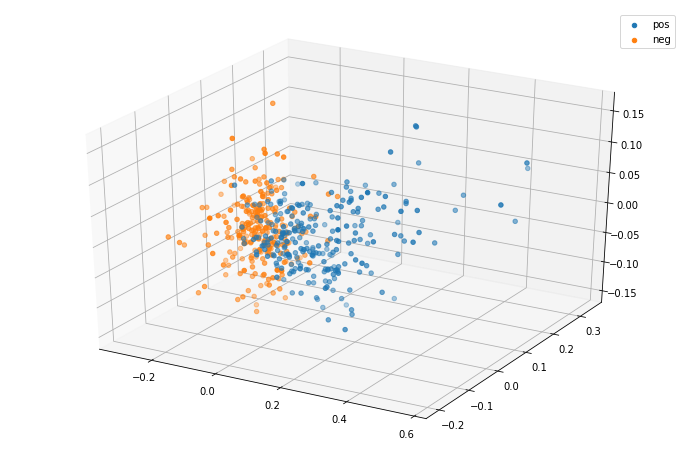

In [41]:
MAX = 250

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_r[pos[:MAX], 0], X_r[pos[:MAX], 1], X_r[pos[:MAX], 2], c='C0', label='pos')
ax.scatter(X_r[neg[:MAX], 0], X_r[neg[:MAX], 1], X_r[pos[:MAX], 2], c='C1', label='neg')
plt.legend();